In [1]:
from __future__ import print_function, division
from random import randint 
from itertools import chain
%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

In [2]:
from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d

class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, r=0.1):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        r: diffusion rate constant
        """
        self.r = r
        m = n if m is None else m
        self.array = np.zeros((n, m), np.float)

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c

In [3]:
class DiffusionViewer(Cell2DViewer):
    cmap = plt.get_cmap('Reds')

In [4]:
diff = Diffusion(n=25, r=.1)
diff.add_cells(25/2,25/2, '1111111111', '11111111', '111111111','11111111')
viewer = DiffusionViewer(diff)

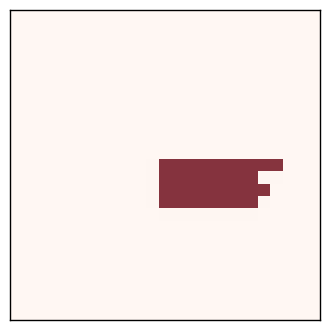

In [5]:
anim = viewer.animate(frames = 100)

In [6]:
anim

## Percolation

In [221]:
class RDViewer(Cell2DViewer):
    """Generates images and animations."""
    
    cmapu = plt.get_cmap('Reds')
    cmapv = plt.get_cmap('Blues')

    options = dict(alpha=0.7,
                  interpolation='bicubic')
        
    def __init__(self, viewee):
        """Initializes the attributes.
        
        viewee: the object to be represented
        """
        self.viewee = viewee
        self.imu = None
        self.imv = None
        self.hlines = None
        self.vlines = None

    def draw(self, grid=False):
        """Draws the cells."""
        au = self.viewee.array.copy()
        av = self.viewee.array2.copy()
        
        n, m = av.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        self.imu = plt.imshow(au, cmap=self.cmapu, **self.options)
        self.imv = plt.imshow(av, cmap=self.cmapv, **self.options)

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step(iters=100)

        self.imu.set_array(self.viewee.array)
        self.imv.set_array(self.viewee.array2)
        return (self.imu, self.imv)

In [253]:
class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[.5, 1, 0.5],
                       [1, -6, 1],
                       [.5, 1, 0.5]])

    def __init__(self, n, m=None, p=0.5, r=0.1, seed = 22):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        r: diffusion rate constant
        """
        self.r = r
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        # fill random areas with inpermiable materials
        self.array2 = np.zeros((n, m), np.float)
        # fill random areas with permiable materials/caverns
        #]self.array = np.zeros((n, m), np.float)
        self.array = np.random.choice([0.0,1.0], (n, m), p=[1-p, p])
        # fill center with gas cells
        self.array[n/2, m/2] = 500
    def step(self):
        """Executes one time step."""
        a = self.array
        a2 = self.array2
        c = correlate2d(a, self.kernel, mode='same')
        if (np.any(a >= 1.0)):
            self.array +=  self.r * c
        else:
            self.array += self.r / c
    def num_wet(self, cols=None):
        """Total number of wet cells.
        
        cols: number of columns to select
        """
        a = self.array[:, :cols]
        return np.sum(a == 1)
    
    def num_porous(self, cols=None):
        """Total number of porous cells."""
        a = self.array2[:, :cols]
        return np.sum(a == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
    def left_row_wet(self):
        """Number of wet cells in the left row."""
        return np.sum(self.array[0,1] == 5)
    def right_row_wet(self):
        """Number of wet cells in the top row."""
        return np.sum(self.array[0,-1] == 5)
    def top_row_wet(self):
        """Number of wet cells in the top row."""
        return np.sum(self.array[1] == 5)
  
  

In [254]:
class PercolationViewer(Cell2DViewer):
    """Draws and animates a Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='none', 
                   vmin=-0, vmax=5)

In [255]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: (boolean, number of steps)
    """
    num_wet = perc.num_wet()

    num_steps = 0
    while True:
        perc.step()
        num_steps += 1

        if perc.bottom_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps
        
        if perc.left_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps
        
        if perc.right_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps
        if perc.top_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps

        num_wet = new_num_wet

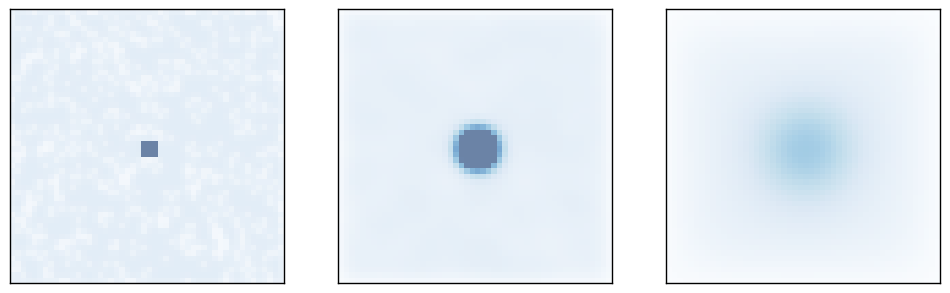

In [256]:
seed = 22
perc = Percolation(50, p=0.8)
viewer = PercolationViewer(perc)

thinkplot.preplot(cols=3)
viewer.step()
viewer.draw()

thinkplot.subplot(2)
viewer.step(10)
viewer.draw()

thinkplot.subplot(3)
viewer.step(100)
viewer.draw()

In [251]:
perc = Percolation(10, p=0.8)
flag, num_steps = test_perc(perc)
print(flag, num_steps)

False 3


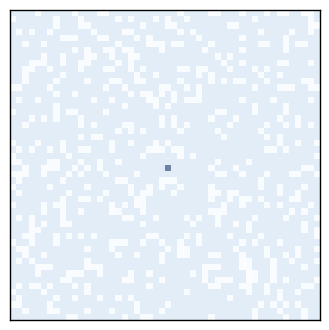

In [226]:
perc = Percolation(50, p=0.8)
viewer = PercolationViewer(perc)
anim = viewer.animate(frames=100)

In [227]:
anim